Implemented following official github of [YoloV5](https://github.com/ultralytics/yolov5/blob/master/models/common.py)

In [36]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib as plt

In [37]:
  class Conv(nn.Module):
    default_act = nn.SiLU()
    def __init__(self, c1, c2, k =1, s=1, p='valid' , g=1 , d=1, act= True):
      super().__init__()
      self.conv=nn.Conv2d(c1 ,c2 ,kernel_size=1, stride=s, padding=p, groups=g, dilation =d, bias=False)
      self.bn = nn.BatchNorm2d(c2)
      nn.act=default_act if act is True else act if isinstance(act,nn.Module) else nn.Identity()
      
      def forward(self, x):
        return self.act(self.bn(self.conv(x)))
      def forward_plain(self,x):
        return self.act(self.conv(x))

  class DWConv(Conv):

    def __init__(self, c1, c2, k=1, s=1, d=1, act=True): 
        super().__init__(c1, c2, k, s, g=np.gcd(c1, c2), d=d, act=act) ##np.gcd can handle array inputs too!
        
  '''Depth-wise transpose convolution
  write fucntion'''
  class DWConvTranspose2d(nn.ConvTranspose2d):
    def __init__(self, c1, c2, k=1, s=1, p1=0, p2=0): 
        super().__init__(c1, c2, k, s, p1, p2, groups=math.gcd(c1, c2))

Convolution -->


1.   Input channels, output channels. o/p channel is determined by no. of filters. Kernel dim is defined.
2.   Before convolutions, we decide whether we want to do padding (adding zeros to prevent downsizing) or not. So, padding and stride of kernel.
3. One may want to use **grouped** convolutions for better processing power and learning. So, a param groups is also in some sense necessary.
[Idea of Grouped convolutions(ref to AlexNet)](https://blog.yani.ai/filter-group-tutorial/)

Hence, we require in_ch, out_ch, kernel(size), padding, groups. Occasionally, we may feel to add bias to convolutions. 

If we want to pad the input image in such a way that size of output is equal to original size of input then we can use `padding ='same'`, however this works only for stride = 1, which is why authors define a custom function `autopad` to do the same. Here, I am not defining any such fucntion. Might do it later.

`isinstance(obj, type)` -- It returns true if the passed object is of passed type. Here, if custom activation function is passed like say ReLU then the fnction `Conv` still works. SiLU is used as default because it performed well during experiments.

**Depth wise convolutions** produce more output channels with less no of inputs because of the way theyare designed. For Normal convolutions produce o/p = no. of filters.

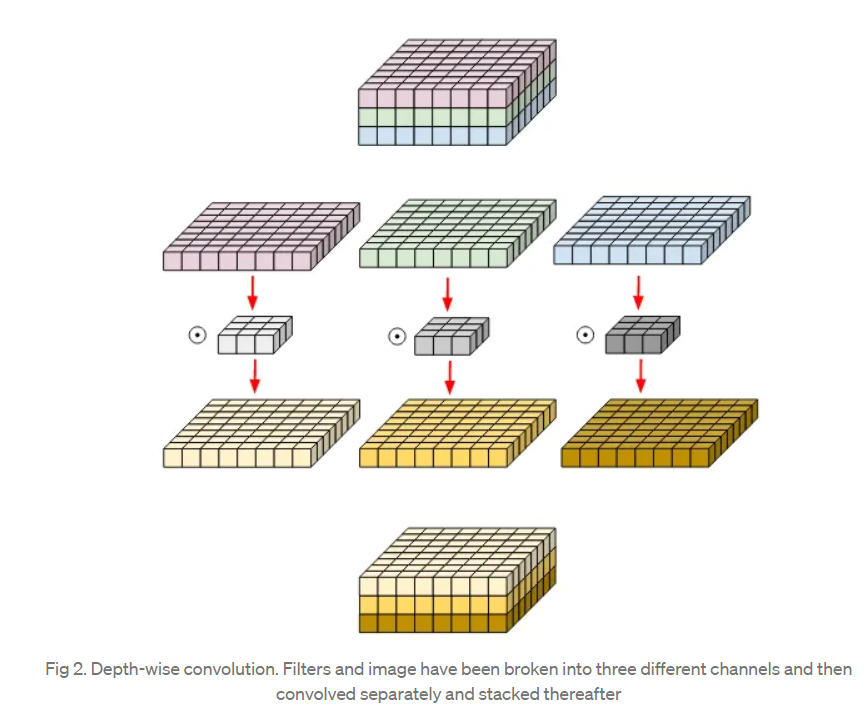

In [38]:
##Transformer block
class TransformerLayer(nn.Module):
    # Transformer layer https://arxiv.org/abs/2010.11929 (LayerNorm layers removed for better performance)
    def __init__(self, c, num_heads):
        super().__init__()
        self.q = nn.Linear(c, c, bias=False)
        self.k = nn.Linear(c, c, bias=False)
        self.v = nn.Linear(c, c, bias=False)
        self.ma = nn.MultiheadAttention(embed_dim=c, num_heads=num_heads)
        self.fc1 = nn.Linear(c, c, bias=False)
        self.fc2 = nn.Linear(c, c, bias=False)

    def forward(self, x):
        x = self.ma(self.q(x), self.k(x), self.v(x))[0] + x
        x = self.fc2(self.fc1(x)) + x
        return x


class TransformerBlock(nn.Module):
    # Vision Transformer https://arxiv.org/abs/2010.11929
    def __init__(self, c1, c2, num_heads, num_layers):
        super().__init__()
        self.conv = None
        if c1 != c2:
            self.conv = Conv(c1, c2)
        self.linear = nn.Linear(c2, c2)  # learnable position embedding
        self.tr = nn.Sequential(*(TransformerLayer(c2, num_heads) for _ in range(num_layers)))
        self.c2 = c2

    def forward(self, x):
        if self.conv is not None:
            x = self.conv(x)
        b, _, w, h = x.shape
        p = x.flatten(2).permute(2, 0, 1)
        return self.tr(p + self.linear(p)).permute(1, 2, 0).reshape(b, self.c2, w, h) 
        #Can we use einops here ??


In [39]:
class CrossConv(nn.Module):
  #cross convolution --> width wise , height wise 
   def __init__(self, c1, c2, k=3, s=1, g=1, e=1.0, shortcut=False):
    super().__init__()
    c_ = int(c2 * e)  # hidden channels
    self.cv1 = Conv(c1, c_, (1, k), (1, s)) 
    self.cv2 = Conv(c_, c2, (k, 1), (s, 1), g=g)
    self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


In [40]:
 class Bottleneck(nn.Module):
  def __init__(self,c1,c2,skip=True,g=1, e=0.5):
    super().__init__()
    c_=int(c2*e)
    #c_=c2//w
    self.cv1=Conv(c1,c_,1,1)
    self.cv2=Conv(c_,c2,3,1, g=g) #why have we used g param here?

    def forward (self, x):
      return x + self.cv2(self.cv1(x)) if skip else self.cv2(self.cv1(x))

  class CSPBottleneck(nn.Module):
    def __init__(self,c1,c2, n=1, shortcut=True, g=1, e=0.5):
      super().__init__()
      c_ = int(c2 * e)  # hidden channels
      self.cv1 = Conv(c1,c_,1,1)
      self.cv2 = nn.Conv2d(c1, c_, 1, 1,bias=False)
      self.cv3 = nn.Conv2d(c_, c_, 1, 1, bias = False)
      '''
      below written code will also do the same thing but by default conv performs bn
      but authors dont use bn on inner layers. There are 2 methods to replicate the same
      using plain Conv2d fn or using forward_plain method of Conv fn. Method 1 was used in official implementation
      
      * self.cv2 = Conv(c1, c_, 1, 1, act = False)
      * self.cv3 = Conv(c_, c_, 1, 1, act = False)
      '''
      self.cv4 = Conv(2*c_,c2,1,1)   #concatenated cv2 and cv3 are passed into this layer, so o/p width increases
      self.act = nn.SiLU()
      self.bn = nn.BatchNorm2d(2*c_) #applied to concat 
      self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n))) #-->Bottlenet

      def forward(self,x):
        y2=self.cv2(x)
        y3=self.cv3(self.cv1(x))
        return self.cv4(self.act(self.bn(torch.cat((y2,y3),1))))

 class C3(nn.Module):
  def __init__(self,c1,c2, n=1, shortcut=True, g=1, e=0.5):
    super().__init__()
    self.cv1 = Conv(c1,c_,1,1)
    self.cv2 = Conv(c_, c_,1, 1)
    self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))
    self.cv3= Conv(2*c_, c2, 1, 1)

    def forward(self,x):
      return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)),1))

 class C3TR(C3):
  def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
    super().__init__(c1, c2, n, shortcut, g, e)
    c_ = int(c2 * e)
    self.m = TransformerBlock(c_, c_, 4, n)

 class C3x(C3):

    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__(c1, c2, n, shortcut, g, e)
        c_ = int(c2 * e)
        self.m = nn.Sequential(*(CrossConv(c_, c_, 3, 1, g, 1.0, shortcut) for _ in range(n)))
 
 class C3SPP(C3):
  def __init__(self, c1, c2, k=(5, 9, 13), n=1, shortcut=True, g=1, e=0.5):
    super().__init__(c1, c2, n, shortcut, g, e)
    c_ = int(c2 * e)
    self.m = SPP(c_, c_, k)


 class C3Ghost(C3):
  def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
    super().__init__(c1, c2, n, shortcut, g, e)
    c_ = int(c2 * e)  # hidden channels
    self.m = nn.Sequential(*(GhostBottleneck(c_, c_) for _ in range(n)))

In [41]:
 #part 2
 class SPP(nn.Module):
  def __init__(self, c1, c2, k=(5, 9, 13)):
    super().__init__()
    c_ = c1 // 2  # hidden channels
    self.cv1 = Conv(c1, c_, 1, 1)
    self.cv2 = Conv(c_ * (len(k) + 1), c2, 1, 1)
    self.m = nn.ModuleList([nn.MaxPool2d(kernel_size=x, stride=1, padding=x // 2) for x in k])

  def forward(self, x):
    x = self.cv1(x)
    with warnings.catch_warnings():
      warnings.simplefilter('ignore')
      return self.cv2(torch.cat([x] + [m(x) for m in self.m], 1))
 class SPPF(nn.Module):
  # equivalent to SPP(k=(5, 9, 13))
  def __init__(self, c1, c2, k=5):
    super().__init__()
    c_ = c1 // 2  # hidden channels
    self.cv1 = Conv(c1, c_, 1, 1)
    self.cv2 = Conv(c_ * 4, c2, 1, 1)
    self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
      x = self.cv1(x)
      with warnings.catch_warnings():
        warnings.simplefilter('ignore') 
        y1 = self.m(x)
        y2 = self.m(y1)
        return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))


  class Focus(nn.Module):
    # passing 50% info from width and height channels
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):  
        super().__init__()
        self.conv = Conv(c1 * 4, c2, k, s, p, g, act=act)
        
    def forward(self, x):  #during concat channels add
        return self.conv(torch.cat((x[..., ::2, ::2], x[..., 1::2, ::2], x[..., ::2, 1::2], x[..., 1::2, 1::2]), 1))
        '''
        Official documentation defines a class Contract with param gain. 
        gain = a, downsamples height and width channel by factor a.
        self.contract= Contract(gain=2)
        //
        return self.conv(self.contract(x))
        '''

Spatial Pyramid Pooling (SPP) layer https://arxiv.org/abs/1406.4729
SPFF is modification of SPP introduced in yolov5

In [42]:
class GhostConv(nn.Module):
    def __init__(self, c1, c2, k=1, s=1, g=1, act=True):  
        c_ = c2 // 2  # hidden channels ---> reduction in out_ch
        self.cv1 = Conv(c1, c_, k, s, None, g, act=act)
        self.cv2 = Conv(c_, c_, 5, 1, None, c_, act=act)

    def forward(self, x):
        y = self.cv1(x)
        return torch.cat((y, self.cv2(y)), 1)
class GhostBottleneck(nn.Module):
    def __init__(self, c1, c2, k=3, s=1):  # ch_in, ch_out, kernel, stride
        super().__init__()
        c_ = c2 // 2
        self.conv = nn.Sequential(
            GhostConv(c1, c_, 1, 1), #pointwise
            DWConv(c_, c_, k, s, act=False) if s == 2 else nn.Identity(),  # dw
            GhostConv(c_, c2, 1, 1, act=False))  # pw-linear
        self.shortcut = nn.Sequential(DWConv(c1, c1, k, s, act=False), Conv(c1, c2, 1, 1,
                                                                            act=False)) if s == 2 else nn.Identity()

    def forward(self, x):
        return self.conv(x) + self.shortcut(x)


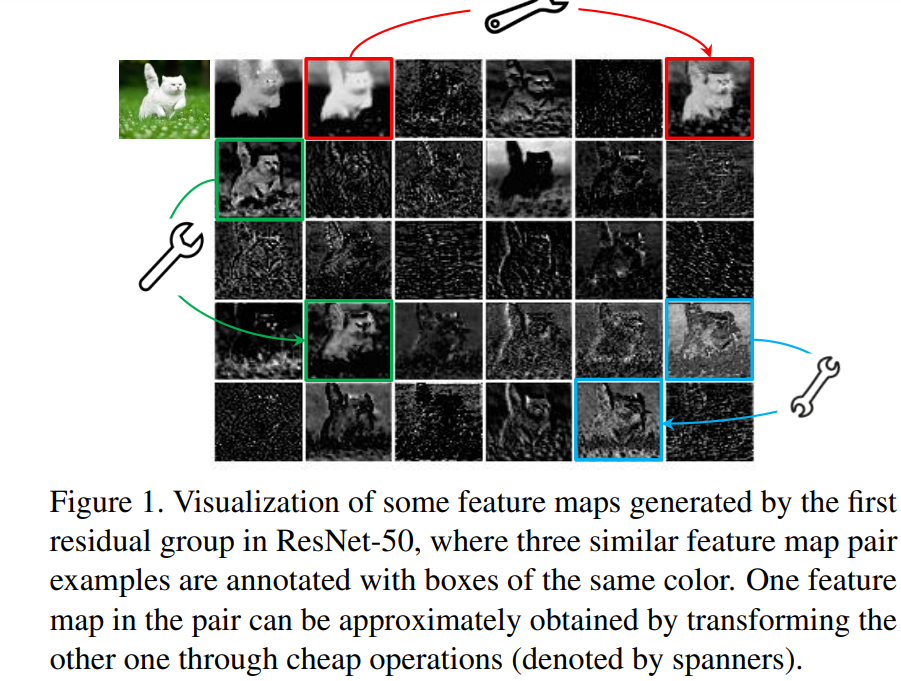

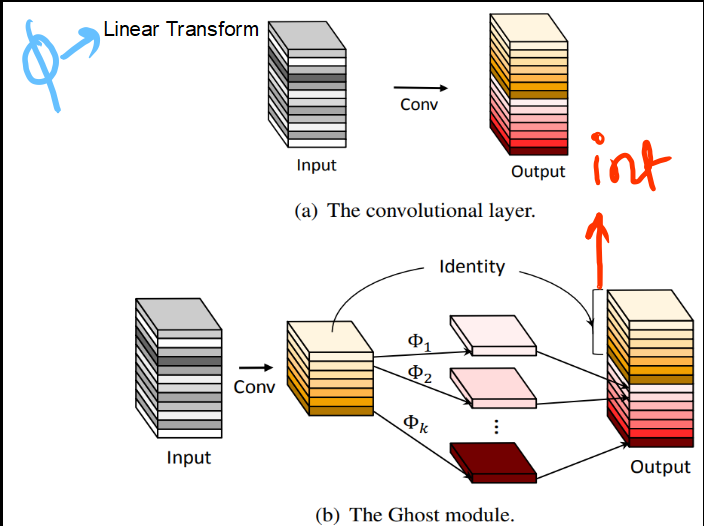

Concept of ghost nets --- [Ghostnets](https://arxiv.org/pdf/1911.11907.pdf)

Figure 1 presents some feature maps of an input image
generated by ResNet-50, and there exist many similar pairs
of feature maps, like a ghost of each another. Redundancy
in feature maps could be an important characteristic for a
successful deep neural network. Instead of avoiding the redundant feature maps, we tend to embrace them, but in a
cost-efficient way - `applying linear transforms to a single common ancestor image`

param redn. See ref image.

Similarly GhostBottleneck consist of sequential ghost module with skip connc.
For stride = 2, the paper inserts a DW block b/w the ghostmodules.

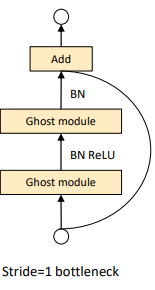

[Einops](https://einops.rocks/) Library

[Video Tutorial](https://www.youtube.com/watch?v=xGy75Pjsqzo)

In [43]:
!pip install einops
from einops import rearrange, reduce, repeat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
class Contract(nn.Module):
    # Contract width-height into channels, i.e. x(1,64,80,80) to x(1,256,40,40)
    def __init__(self, gain=2):
        super().__init__()
        self.gain = gain

    def forward(self, x):
        b, c, h, w = x.size()  # assert (h / s == 0) and (W / s == 0), 'Indivisible gain'
        s = self.gain
        x = x.view(b, c, h // s, s, w // s, s)  # x(1,64,40,2,40,2)
        x = x.permute(0, 3, 5, 1, 2, 4).contiguous()  # x(1,2,2,64,40,40)
        #x= rearrange(x, 'b c h s1 w s2 -> b s1 s2 c h w')
        return x.view(b, c * s * s, h // s, w // s)  # x(1,256,40,40)

class Expand(nn.Module):
    # Expand channels into width-height, i.e. x(1,64,80,80) to x(1,16,160,160)
    def __init__(self, gain=2):
        super().__init__()
        self.gain = gain

    def forward(self, x):
        b, c, h, w = x.size()  # assert C / s ** 2 == 0, 'Indivisible gain'
        s = self.gain
        x = x.view(b, s, s, c // s ** 2, h, w)  # x(1,2,2,16,80,80)
        #x = x.permute(0, 3, 4, 1, 5, 2).contiguous()  # x(1,16,80,2,80,2)
        x=rearrange(x, 'b s1 s2 c h w -> b c h s1 w s2' )
        #return x.view(b, c // s ** 2, h * s, w * s)  # x(1,16,160,160)
        return (rearrange(x, 'b c h s1 w s2 -> b c (h s1) (w s2)' ))

''' Concat fn is rather uncessary except to enhance readibility of code'''
class Concat(nn.Module):
    # Concatenate a list of tensors along dimension
    def __init__(self, dimension=1):
        super().__init__()
        self.d = dimension

    def forward(self, x):
        return torch.cat(x, self.d)
